In [129]:
%load_ext autoreload
%autoreload 2

import os
import multiprocessing

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)

import batman
import gpjax as gpx
import jax.numpy as jnp
from jax import jit
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from beartype.typing import Callable
from gpjax.kernels import RBF, Linear, Periodic, PoweredExponential
from jaxoplanet.light_curves import LimbDarkLightCurve
from jax.tree_util import tree_leaves, tree_structure

from jaxoplanet import orbits
from gpjax.typing import (
    Array,
    ScalarFloat,
)

from kernels import OrnsteinUhlenbeck
from kernelsearch import KernelSearch, describe_kernel, get_trainables, jit_set_trainables

import emcee

rng = np.random.default_rng(seed=42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

In [131]:
# def calculate_lightcurve(t, params):
#     param_container = batman.TransitParams()
#     param_container.t0 = params[0]  # time of inferior conjunction
#     param_container.per = 1.0  # orbital period
#     param_container.rp = params[1]  # planet radius (in units of stellar radii)
#     param_container.a = params[2]  # semi-major axis (in units of stellar radii)
#     param_container.inc = 87.0  # orbital inclination (in degrees)
#     param_container.ecc = 0.0  # eccentricity
#     param_container.w = 90.0  # longitude of periastron (in degrees)
#     param_container.u = [params[3], params[4]]  # limb darkening coefficients [u1, u2]
#     param_container.limb_dark = "quadratic"  # limb darkening model

#     m = batman.TransitModel(param_container, t)  # initializes model
#     return m.light_curve(param_container)


@jit
def calculate_lightcurve(t, params):
    # The light curve calculation requires an orbit
    orbit = orbits.keplerian.Body(
        period=params["period"],
        radius=params["radius"],
        inclination=params["inclination"],
        time_transit=params["time_transit"],
    )

    lc = LimbDarkLightCurve(params["u"]).light_curve(orbit, t=t)
    return lc

In [132]:
t = np.linspace(-0.2, 0.4, 1000)

true_params = {
    "period": 15,  # period in days
    "radius": 0.1,
    "inclination": jnp.deg2rad(89),
    "time_transit": 0,
    "u": jnp.array([0.1, 0.3]),
}


true_lightcurve = calculate_lightcurve(
    t=t,
    # params=[0, 0.1, 15, 0.1, 0.3],
    params=true_params,
)

In [133]:
test_ind = np.sort(rng.choice(len(t), 150))
t_train = t[test_ind]
lc_latent = (
    true_lightcurve
    - 0.05 * np.cos(20 * t / (2 * np.pi))
    + 0.08 * (((t - 0.05) / t[-1]) ** 2) * np.sin(400 * t / (2 * np.pi))
)
lc_train = lc_latent[test_ind] + rng.normal(scale=0.003, size=len(test_ind))

In [134]:
mask = jnp.array(~np.ma.masked_where((-0.1 < t_train) & (t_train < 0.1), t_train).mask)

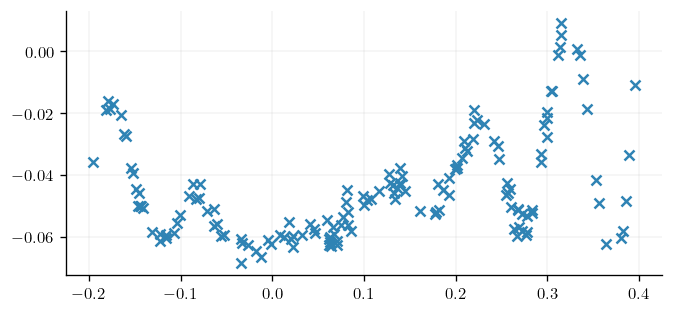

In [135]:
# plt.plot(t, true_lightcurve)
plt.scatter(t_train, lc_train)

In [136]:
kernel_library = [
    Linear(),
    RBF(),
    OrnsteinUhlenbeck(),
    Periodic(),
    # PoweredExponential(power=jnp.array(0.5)),
]  # default powered exponential has infinite parameter for some reason

In [137]:
tree = KernelSearch(
    kernel_library,
    X=jnp.array(t_train[mask]),
    y=jnp.array(lc_train[mask]),
    obs_stddev=0.003,
    verbosity=1,
)

model = tree.search(
    depth=1,  # 7
    n_leafs=1,  # 3
    patience=1,
)

Fitting Layer 1: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

Layer 1 || Current AICs: [-818.1517526806291, -748.4326837454688, -719.7870366910872, 11946.263191677544]
Terminated on layer: 1.
Final log likelihood: 411.07587634031455
Final number of model paramter: 2


In [138]:
describe_kernel(model)

'RBF'

In [139]:
latent_dist = model(t.reshape(-1, 1), train_data=tree.data)
predictive_dist = model.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

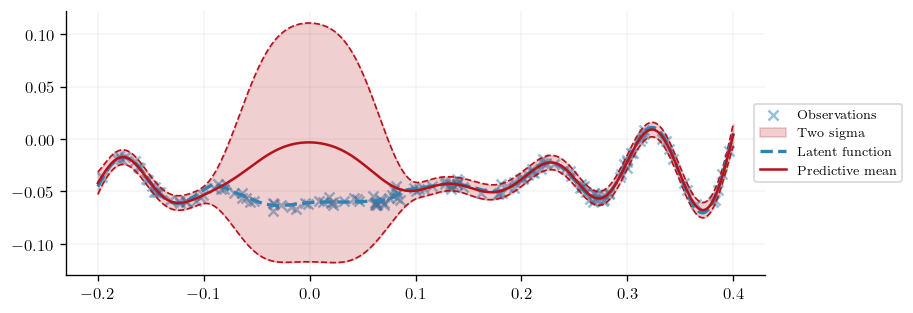

In [140]:
fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.scatter(t_train, lc_train, label="Observations", color=cols[0], alpha=0.5)
ax.fill_between(
    t,
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    t,
    predictive_mean - 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    t,
    predictive_mean + 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    t,
    lc_latent,
    label="Latent function",
    color=cols[0],
    linestyle="--",
    linewidth=2,
)
ax.plot(t, predictive_mean, label="Predictive mean", color=cols[1])
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))

## TEST MCMC

In [141]:
import jax
import blackjax
from gpjax.objectives import AbstractObjective
from blackjax.progress_bar import progress_bar_scan

key = jax.random.PRNGKey(123)

In [142]:
@jit
def lc_model(t, params):
    # The light curve calculation requires an orbit
    orbit = orbits.keplerian.Body(
        period=15,
        radius=params[0],
        inclination=jnp.deg2rad(89),
        time_transit=0,
    )

    lc = LimbDarkLightCurve([params[2], params[3]]).light_curve(orbit, t=t)
    return lc

In [143]:
# replace this by something that takes params explcitly as input, to MCMC sample
def make_logprob_func(
    gp_posterior: gpx.gps.AbstractPosterior,
    lc_model: Callable,
    X,
    y,
    mask,
):
    D = gpx.Dataset(X=X.reshape(-1, 1), y=y.reshape(-1, 1))
    D_masked = gpx.Dataset(X=X[mask].reshape(-1, 1), y=y[mask].reshape(-1, 1))
    trainable_idx = jnp.argwhere(jnp.array(tree_leaves(model.trainables()))).reshape(-1)

    # @jit
    def objective(params):
        x, y = D.X, D.y

        updated_posterior = jit_set_trainables(
            gp_posterior,
            jnp.array(params["gp_parameter"]),
            trainable_idx,
        ).constrain()

        latent_dist = updated_posterior(
            x,
            train_data=D_masked,
        )
        predictive_dist = updated_posterior.likelihood(
            latent_dist
        )  # adds observational uncertainty

        lightcurve = lc_model(x, params["lc_parameter"])

        res = (y - lightcurve).reshape(-1)
        log_prob = predictive_dist.log_prob(res)

        return jnp.nan_to_num(log_prob, nan=-jnp.inf)

    return objective

In [144]:
objective = make_logprob_func(model.unconstrain(), lc_model, t_train, lc_train, mask)


gp_initial_params = get_trainables(model, unconstrain=True)
initial_params = {
    "gp_parameter": get_trainables(model, unconstrain=True),
    "lc_parameter": jnp.asarray([0.2, 1.5, 0, 0.5]),
}

In [173]:
# Adapted from BlackJax's introduction notebook.
num_adapt = 5
num_samples = 5
num_chains = 4

warmup = blackjax.window_adaptation(
    blackjax.nuts,
    objective,
    target_acceptance_rate=0.65,
    progress_bar=True,
)
rng_key, warmup_key, sample_key = jax.random.split(key, 3)
(state, parameters), _ = warmup.run(warmup_key, initial_params, num_steps=num_adapt)

Running window adaptation


In [192]:
def run_inference_algorithm(
    rng_key,
    initial_state_or_position,
    inference_algorithm,
    num_steps: int,
    progress_bar: bool = False,
) -> tuple:
    init_key, sample_key = jax.random.split(rng_key, 2)
    try:
        initial_state = inference_algorithm.init(initial_state_or_position, init_key)
    except (TypeError, ValueError, AttributeError):
        # We assume initial_state is already in the right format.
        initial_state = initial_state_or_position

    keys = jax.random.split(sample_key, num_steps)

    @jit
    def _one_step(state, xs):
        _, rng_key = xs
        state, info = inference_algorithm.step(rng_key, state)
        return state, (state, info)

    if progress_bar:
        one_step = progress_bar_scan(num_steps)(_one_step)
    else:
        one_step = _one_step

    xs = (jnp.arange(num_steps), keys)
    final_state, (state_history, info_history) = jax.lax.scan(
        one_step, initial_state, xs
    )
    return final_state, state_history, info_history

In [195]:
nuts = blackjax.nuts(objective, **parameters)

initial_positions = {
    "gp_parameter": jnp.tile(state.position["gp_parameter"], (num_chains, 1)),
    "lc_parameter": jnp.tile(state.position["lc_parameter"], (num_chains, 1)),
}

initial_states = jax.vmap(nuts.init, in_axes=(0))(initial_positions)

inference_loop_multiple_chains = jax.pmap(
    run_inference_algorithm,
    in_axes=(0, 0, None, None, None),
    static_broadcasted_argnums=(2, 3, 4),
)
rng_key, sample_key = jax.random.split(key)
sample_keys = jax.random.split(sample_key, num_chains)

In [196]:
pmap_states = inference_loop_multiple_chains(
    sample_keys,
    initial_states,
    nuts,
    num_samples,
    False,
)

# final_state, state_history, info_history = run_inference_algorithm(
#     sample_key, state, nuts, num_steps=num_samples, progress_bar=True
# )

In [233]:
pmap_states[1].position["gp_parameter"]

Array([[[-2.95398062, -5.95349622],
        [-2.95398062, -5.95349622],
        [-2.95398062, -5.95349622],
        [-2.95398062, -5.95349622],
        [-2.95398062, -5.95349622]],

       [[-2.95398062, -5.95349622],
        [-2.95398062, -5.95349622],
        [-2.95398062, -5.95349622],
        [-2.95398062, -5.95349622],
        [-2.95398062, -5.95349622]],

       [[-2.95398062, -5.95349622],
        [-2.95398062, -5.95349622],
        [-3.17552614, -6.07371894],
        [-3.38550866, -6.03302823],
        [-3.31408155, -6.02775299]],

       [[-2.95398062, -5.95349622],
        [-2.95398062, -5.95349622],
        [-2.95398062, -5.95349622],
        [-2.95398062, -5.95349622],
        [-2.95398062, -5.95349622]]], dtype=float64)